In [1]:
import os
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras import Model

In [2]:
# Download the inception v3 weights
!wget --no-check-certificate \
    https://storage.googleapis.com/mledu-datasets/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5 \
    -O /tmp/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5

# Import the inception model  
from tensorflow.keras.applications.inception_v3 import InceptionV3

# Create an instance of the inception model from the local pre-trained weights
local_weights_file = '/tmp/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5'

pre_trained_model = InceptionV3(
    input_shape=(150, 150, 3),
    include_top=False,
    weights=None
)

pre_trained_model.load_weights(local_weights_file)

# Make all the layers in the pre-trained model non-trainable
for layer in pre_trained_model.layers:
  layer.trainable = False

# Print the model summary
pre_trained_model.summary()

--2023-04-01 07:49:36--  https://storage.googleapis.com/mledu-datasets/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5
Resolving storage.googleapis.com (storage.googleapis.com)... 173.194.79.128, 108.177.127.128, 172.217.218.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|173.194.79.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 87910968 (84M) [application/x-hdf]
Saving to: ‘/tmp/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5’

/tmp/inception_v3_w 100%[===================>]  83.84M  27.3MB/s    in 3.1s    

2023-04-01 07:49:39 (27.3 MB/s) - ‘/tmp/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5’ saved [87910968/87910968]

Model: "inception_v3"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 150, 150, 3  0           []  

In [3]:
last_layer = pre_trained_model.get_layer('mixed7')
print('last layer output shape: ', last_layer.output_shape)
last_output = last_layer.output

last layer output shape:  (None, 7, 7, 768)


In [4]:
class myCallback(tf.keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs={}):
    if(logs.get('accuracy')>0.999):
      print("\nReached 99.9% accuracy so cancelling training!")
      self.model.stop_training = True

In [5]:
from tensorflow.keras.optimizers import RMSprop

# Flatten the output layer to 1 dimension
x = layers.Flatten()(last_output)
# Add a fully connected layer with 1,024 hidden units and ReLU activation
x = layers.Dense(1024, activation='relu')(x)
# Add a dropout rate of 0.2
x = layers.Dropout(.2)(x)                  
# Add a final sigmoid layer for classification
x = layers.Dense(1, activation='sigmoid')(x)           

model = Model(pre_trained_model.input, x) 

model.compile(
    optimizer=RMSprop(lr=0.0001), 
    loss='binary_crossentropy', 
    metrics=['accuracy']
)

model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 150, 150, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 74, 74, 32)   864         ['input_1[0][0]']                
                                                                                                  
 batch_normalization (BatchNorm  (None, 74, 74, 32)  96          ['conv2d[0][0]']                 
 alization)                                                                                       
                                                                                              

In [6]:
from google.colab import drive
drive.mount("/content/gdrive")

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [7]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [8]:
train_datagen = ImageDataGenerator(
    rescale = 1./255.,
    rotation_range = 40,
    width_shift_range = 0.2,
    height_shift_range = 0.2,
    shear_range = 0.2,
    zoom_range = 0.2,
    horizontal_flip = True
)

# Note that the validation data should not be augmented!
test_datagen = ImageDataGenerator(
    rescale = 1./255.
)

# Flow training images in batches of 20 using train_datagen generator
train_generator = train_datagen.flow_from_directory(
    '/content/gdrive/MyDrive/Classification/Train/',
    batch_size=64,
    class_mode='binary',
    target_size=(150,150)
)     

# Flow validation images in batches of 20 using test_datagen generator
validation_generator =  test_datagen.flow_from_directory(
    '/content/gdrive/MyDrive/Classification/Validation/',
    batch_size=64,
    class_mode='binary',
    target_size=(150,150)
)

Found 1279 images belonging to 2 classes.
Found 323 images belonging to 2 classes.


In [9]:
callbacks = myCallback()
history= model.fit(
    train_generator,
    epochs=100,
    validation_data=validation_generator,
    callbacks=[callbacks]
)

Epoch 1/100
20/20 [==============================] - 32s 1s/step - loss: 3.2497 - accuracy: 0.5934 - val_loss: 0.4490 - val_accuracy: 0.7895
Epoch 2/100
20/20 [==============================] - 22s 1s/step - loss: 0.5489 - accuracy: 0.7115 - val_loss: 0.3454 - val_accuracy: 0.8297
Epoch 3/100
20/20 [==============================] - 25s 1s/step - loss: 0.4708 - accuracy: 0.7787 - val_loss: 0.2930 - val_accuracy: 0.8700
Epoch 4/100
20/20 [==============================] - 21s 1s/step - loss: 0.4089 - accuracy: 0.8155 - val_loss: 0.2893 - val_accuracy: 0.8390
Epoch 5/100
20/20 [==============================] - 22s 1s/step - loss: 0.3895 - accuracy: 0.8217 - val_loss: 0.2910 - val_accuracy: 0.8359
Epoch 6/100
20/20 [==============================] - 21s 1s/step - loss: 0.3236 - accuracy: 0.8585 - val_loss: 0.6646 - val_accuracy: 0.7028
Epoch 7/100
20/20 [==============================] - 23s 1s/step - loss: 0.3423 - accuracy: 0.8413 - val_loss: 0.2455 - val_accuracy: 0.8731
Epoch 8/100
2

In [10]:
model.save("/content/classification_model.h5")

In [11]:
model.save("/content/gdrive/MyDrive/Classification/classification_model2.pb")

KeyboardInterrupt: ignored

In [ ]:
model = tf.keras.models.load_model('/content/classification_model.h5')
converter = tf.lite.TFLiteConverter.from_keras_model(model)
tflite_model = converter.convert()
open("/content/gdrive/MyDrive/Classification/converted_model_2.tflite", "wb").write(tflite_model)

In [ ]:
model.save("/content/gdrive/MyDrive/Classification/classification_model2.h5")

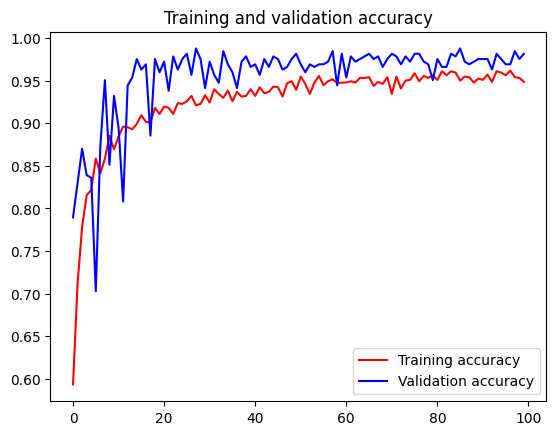

<Figure size 640x480 with 0 Axes>

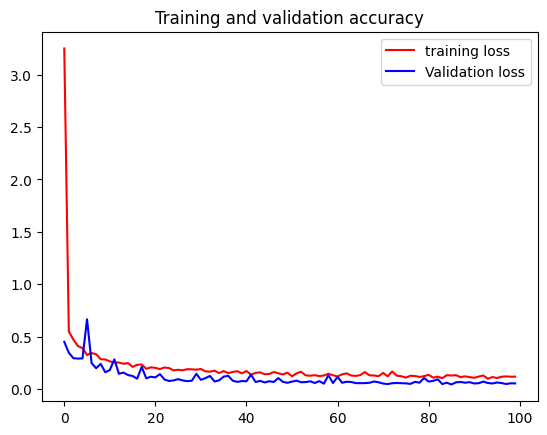

<Figure size 640x480 with 0 Axes>

In [15]:
import matplotlib.pyplot as plt
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'r', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend(loc=0)
plt.figure()
plt.show()

plt.plot(epochs, loss, 'r', label='training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation accuracy')
plt.legend(loc=0)
plt.figure()

plt.show()